In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, matthews_corrcoef
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
%matplotlib inline

In [4]:
# Load the dataset
file_path = "./UAVNet-Defense Comprehensive UAV Network Traffic Dataset.csv"
df = pd.read_csv(file_path)

In [5]:
# Encode 'Protocol' and 'label'
protocol_encoder = LabelEncoder()
df["Protocol"] = protocol_encoder.fit_transform(df["Protocol"])

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])
print("\nLabel Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Label Mapping: {'AODV Attack': 0, 'Flooding Attack': 1, 'Legitimate AODV Traffic': 2, 'Normal Traffic': 3, 'Sybil Attack': 4}


In [6]:
# Define feature columns and label column
feature_columns = [
    "FlowDuration/s", "SrcPort", "DstPort", "Protocol",
    "TxPackets", "RxPackets", "LostPackets", "TxBytes", "RxBytes",
    "TxPacketRate/s", "RxPacketRate/s", "TxByteRate/s", "RxByteRate/s",
    "MeanDelay/s", "MeanJitter/s", "Throughput/Kbps",
    "MeanPacketSize", "PacketDropRate", "AverageHopCount"
]
label_column = "label"

In [7]:
# Apply RobustScaler
scaler = RobustScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

In [8]:
# Prepare the data
X = df[feature_columns].values
y = to_categorical(df[label_column])
n_classes = y.shape[1]

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 34236, Testing samples: 8559


In [10]:
# Define the advanced DNN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

In [11]:
# Compile the model with AdamW optimizer
optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print("\nAdvanced DNN Model Summary:")
model.summary()


Advanced DNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,021 (2.77 MB)

 Trainable params: 722,053 (2.75 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [12]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch > 20:
        return lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [13]:
# Train the model with early stopping and learning rate scheduler
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stopping, lr_scheduler, reduce_lr],
    verbose=2
)

Epoch 1/100
375/375 - 11s - 29ms/step - accuracy: 0.8392 - loss: 0.6454 - val_accuracy: 0.8583 - val_loss: 0.4991 - learning_rate: 0.0010
Epoch 2/100
375/375 - 6s - 15ms/step - accuracy: 0.8837 - loss: 0.4515 - val_accuracy: 0.8615 - val_loss: 0.4404 - learning_rate: 0.0010
Epoch 3/100
375/375 - 4s - 12ms/step - accuracy: 0.8955 - loss: 0.4060 - val_accuracy: 0.8840 - val_loss: 0.4005 - learning_rate: 0.0010
Epoch 4/100
375/375 - 4s - 12ms/step - accuracy: 0.8971 - loss: 0.3856 - val_accuracy: 0.8911 - val_loss: 0.3699 - learning_rate: 0.0010
Epoch 5/100
375/375 - 4s - 10ms/step - accuracy: 0.9018 - loss: 0.3662 - val_accuracy: 0.8985 - val_loss: 0.3510 - learning_rate: 0.0010
Epoch 6/100
375/375 - 4s - 10ms/step - accuracy: 0.9033 - loss: 0.3585 - val_accuracy: 0.8981 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 7/100
375/375 - 4s - 10ms/step - accuracy: 0.9072 - loss: 0.3404 - val_accuracy: 0.8942 - val_loss: 0.3327 - learning_rate: 0.0010
Epoch 8/100
375/375 - 4s - 11ms/step - a

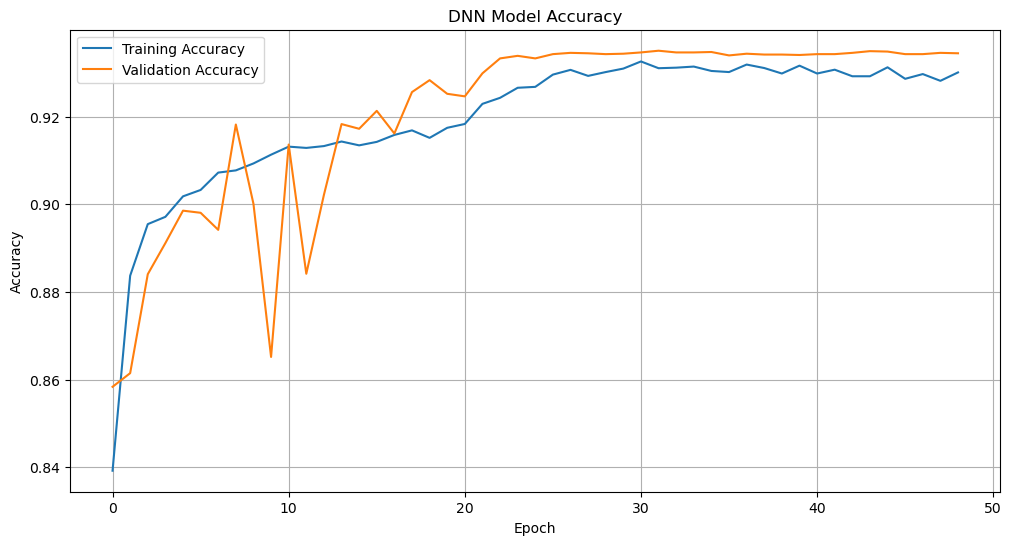

In [14]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("model_accuracy_dnn.png", dpi=300, bbox_inches='tight')
plt.show()

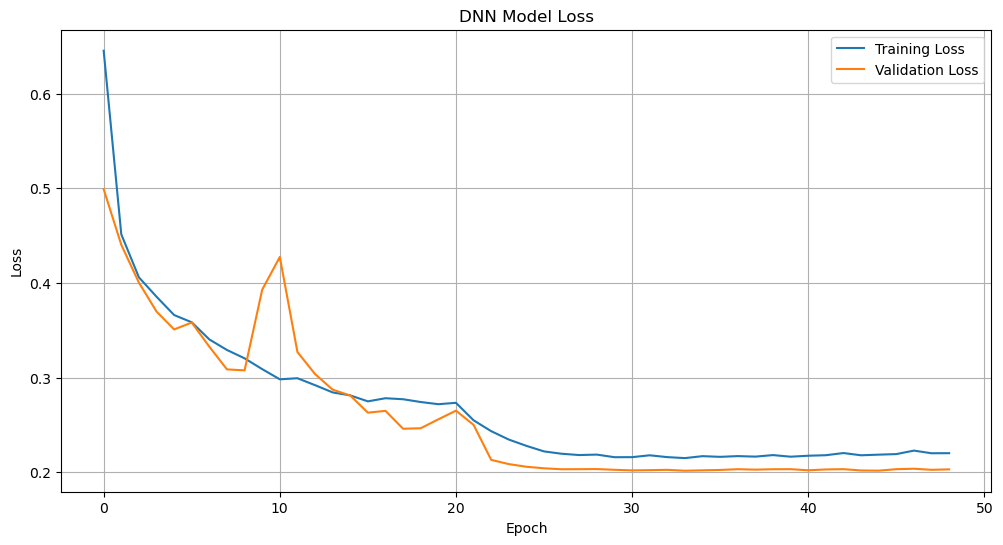

In [15]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('DNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("model_loss_dnn.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Make predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_classes = np.argmax(y_test, axis=1)

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred, target_names=label_encoder.classes_))


Classification Report:
                         precision    recall  f1-score   support

            AODV Attack       0.95      0.89      0.92      1813
        Flooding Attack       0.53      0.92      0.68       194
Legitimate AODV Traffic       0.96      0.98      0.97      5155
         Normal Traffic       0.93      0.99      0.96      1150
           Sybil Attack       0.97      0.15      0.25       247

               accuracy                           0.94      8559
              macro avg       0.87      0.79      0.76      8559
           weighted avg       0.95      0.94      0.93      8559



In [18]:
# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test_classes, y_pred)
print(f"\nMatthews Correlation Coefficient (MCC): {mcc:.4f}")


Matthews Correlation Coefficient (MCC): 0.8923


In [19]:
# F1-Score by Class
f1_scores = f1_score(y_test_classes, y_pred, average=None)
for idx, score in enumerate(f1_scores):
    print(f"F1-Score for {label_encoder.inverse_transform([idx])[0]}: {score:.4f}")

F1-Score for AODV Attack: 0.9177
F1-Score for Flooding Attack: 0.6755
F1-Score for Legitimate AODV Traffic: 0.9721
F1-Score for Normal Traffic: 0.9608
F1-Score for Sybil Attack: 0.2535


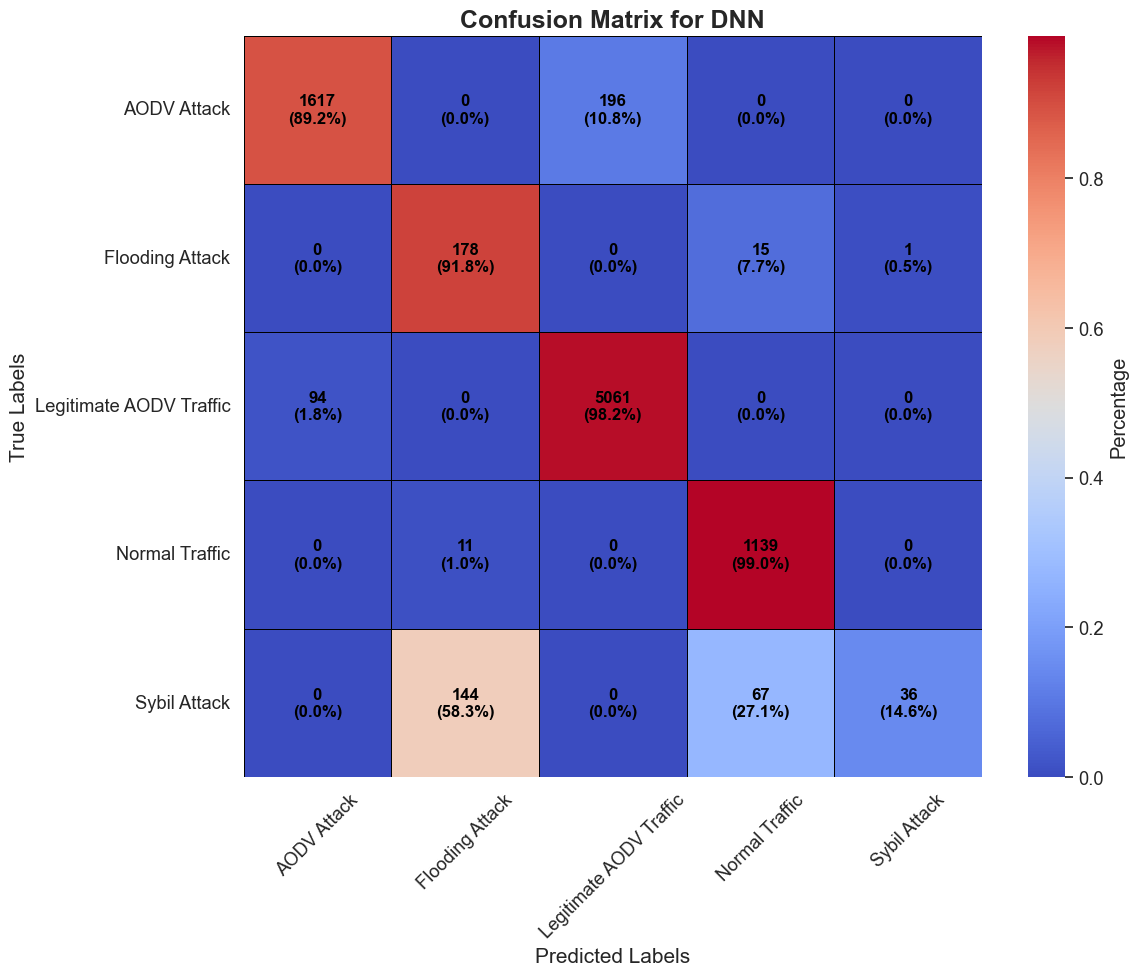

In [23]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)
cmap = sns.color_palette("coolwarm", as_cmap=True)

heatmap = sns.heatmap(conf_matrix_normalized, annot=False, cmap=cmap, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, linewidths=0.5, linecolor='black', cbar_kws={'label': 'Percentage'})

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        percentage = conf_matrix_normalized[i, j] * 100
        heatmap.text(j + 0.5, i + 0.5, f"{count}\n({percentage:.1f}%)", ha='center', va='center', color="black", fontsize=12, fontweight='bold')

# Set titles, labels, and formatting
plt.title("Confusion Matrix for DNN", fontsize=18, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=15)
plt.ylabel("True Labels", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix_dnn.png", dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


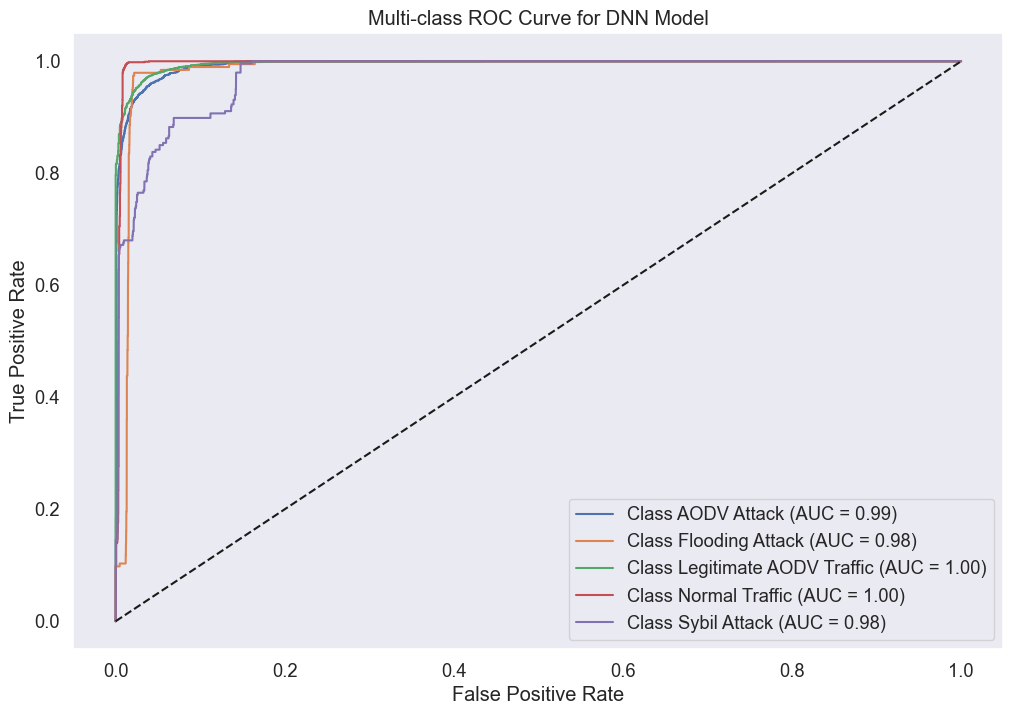

In [25]:
# ROC Curve
y_test_binarized = y_test
y_score = model.predict(X_test)

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multi-class ROC Curve for DNN Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("multi_class_roc_curve_dnn.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Save the trained DNN model
model.save("advanced_dnn_uav_traffic_model.keras")
print("\nModel saved as 'advanced_dnn_uav_traffic_model.keras'")